# Spectroscopic Classification

This notebook assigns Branch et al. 2006 style subtypes to SDSS spectra.

#### Table of Contents:
1. <a href='#spectral_binning'>Spectral Binning</a>: A reminder of some of the manipulations performed on each spectrum during the analysis.
1. <a href='#reading_in_data'>Reading in the Data</a>: A cursory inspection of the data
1. <a href='#peak'>Closest Measurement to Peak Brightness</a>: Selecting only measurements near peak brightness
1. <a href='#resampling'>The Effect of Resampling</a>: Plots Si ii λ5972 vs Si ii λ6355 for different amounts of resampling

In [1]:
import math
import sys
import warnings
from datetime import datetime
from functools import reduce
from pathlib import Path

import numpy as np
import pandas as pd
from astropy.table import Table
from matplotlib import pyplot as plt
from sndata.sdss import sako18spec
from sndata.csp import dr1

sys.path.insert(0, '../')
from phot_class import spectra as spec_class

dr1.download_module_data()
sako18spec.download_module_data()

# Output directory for figures
fig_dir = Path('./notebook_figs/pew_measurements')
fig_dir.mkdir(exist_ok=True, parents=True)


# Spectral Binning <a id='spectral_binning'></a>

We pause for a moment and remind ourselves that the values we are working with in this notebook are calculated after each spectra is restframed, corrected for Milky Way extinction, and binned to a resolution of five (unless otherwise noted) angstroms.


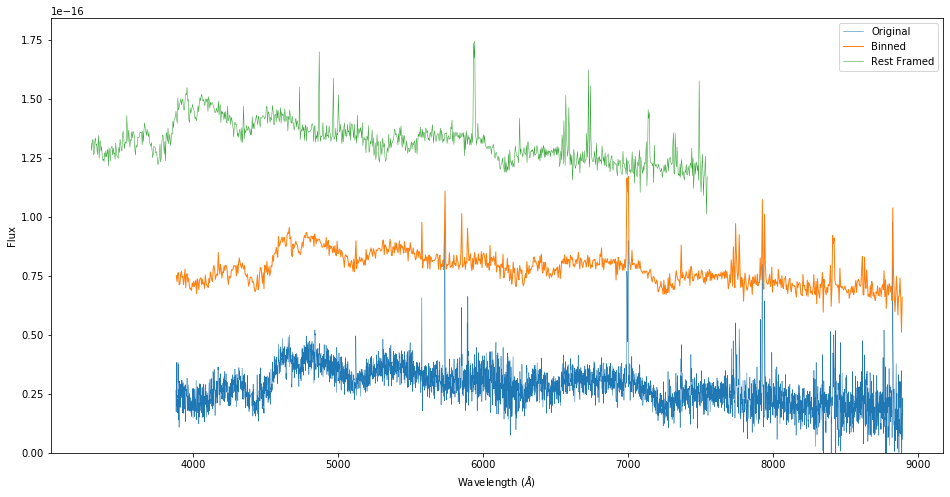

In [5]:
data = sako18spec.get_data_for_id('5635')
wave = data['wavelength']
flux = data['flux']
z = data.meta['z']
ra = data.meta['ra']
dec = data.meta['dec']

# Bin the flux and calculate the average in each bin
bin_wave, bin_flux = spec_class.bin_spectrum(wave, flux)

# Correct for exctinction and shift to rest frame
rest_wave, rest_flux = spec_class.correct_extinction(bin_wave, bin_flux, ra, dec, z)

plt.figure(figsize=(16, 8))
plt.plot(wave, flux, linewidth=.5, label='Original')
plt.plot(bin_wave, bin_flux + 5e-17, linewidth=1, label='Binned')
plt.plot(rest_wave, rest_flux + 1e-16, linewidth=.5, label='Rest Framed')

plt.ylim(ymin=0)
plt.ylabel('Flux')
plt.xlabel(r'Wavelength ($\AA$)')
plt.legend()


## Reading in the Data <a id='reading_in_data'></a>

We read in measurements from external publications.

In [6]:
folatelli_13 = dr1.load_table(6).to_pandas()
branch_06 = pd.DataFrame({
    'obj_id': ['1981B', '1984A', '1986G', '1989B', '1990N', '1991M', '1991T', '1991bg', '1992A', '1994D', '1194ae', '1996X', '1997cn', '1998ag', '1998bu', '1999aw', '1999by', '1999ee', '2000cx', '2001ay', '2001el', '2002bf', '2002bo', '2002cx'],
    'pw7': [127, 204, 126, 124, 88, 137, 29, 92, 107, 96, 89, 87, 101, 78, 94, 58, 95, 82, 51, 150, 95, 171, 146, 18 ],
    'pw6': [17, 23, 33, 20, 12, 19, 0, 49, 19, 19, 7, 17, 45, 12, 16, 1, 46, 5, 2, 8, 16, 10, 11, 0]
})


Next we read in spectroscopic measurements from the analysis pipeline. We include results determined using a range of resampling sizes.

In [7]:
@np.vectorize
def calc_julian_date(date):
    """
    Convert a datetime object into julian float.
    
    Args:
        date (str): The date to convert in %Y-%m-%d format

    Returns:
        The Julian date as a float
    """

    
    date = datetime.strptime(date, '%Y-%m-%d')
    julian_datetime = (
        367 * date.year - 
        int((7 * (date.year + int((date.month + 9) / 12.0))) / 4.0) + 
        int((275 * date.month) / 9.0) + date.day + 
        1721013.5 + 
        (date.hour + date.minute / 60.0 + date.second / math.pow(60, 2)) / 24.0 - 
        0.5 * math.copysign(1, 100 * date.year + date.month - 190002.5) + 0.5
    )

    return julian_datetime


def read_spec_results(path):
    """Read in spectroscopic measurements from the analysis pipeline
    
    Args:
        path (str): The path of the ecsv file to read
        
    Returns:
        A Pandas DataFrame
    """

    # Read in pipeline results
    spec_class = Table.read(path).to_pandas()
    spec_class.set_index(['obj_id', 'feat_name'], inplace=True)
    spec_class['jd'] = calc_julian_date(spec_class.date)
    
    # Get time of peak brightness
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        master = sako18spec.load_table('master').to_pandas()
        master = master.rename(columns={'CID': 'obj_id'}).set_index('obj_id')

    # Calculate days since maximum
    peak_jd = master.MJDatPeakrmag + 2400000.5
    spec_class['days'] = spec_class.jd - peak_jd
    
    return spec_class


In [17]:
peak = sako18spec.load_table('master').to_pandas(index='CID')['MJDatPeakrmag']
peak += 2400000.5
peak

CID
679      2453699.7
680      2453685.6
682      2453656.7
685      2453656.7
688      2453616.8
           ...    
22256    2454389.0
22257    2454433.9
22258    2454433.7
22282    2454406.8
22284    2454433.7
Name: MJDatPeakrmag, Length: 10258, dtype: float64

In [24]:
obj_id = '10096'
target_data = sako18spec.get_data_for_id(obj_id)
target_data = target_data[target_data['type'] != 'Gal']
target_data['date'] = calc_julian_date(target_data['date'])
target_data['days'] = target_data['date'] - peak.loc[obj_id]
target_data

wavelength,flux,sid,type,date,telescope,days
float64,float64,str3,str3,float64,str3,float64
3602.42143964775,-4.579894e-16,532,Ia,2453700.5,APO,6.7000000001862645
3604.84287929551,9.370516e-17,532,Ia,2453700.5,APO,6.7000000001862645
3607.26431894326,2.933179e-16,532,Ia,2453700.5,APO,6.7000000001862645
3609.68575859101,3.594001e-16,532,Ia,2453700.5,APO,6.7000000001862645
3612.10719823877,-1.823099e-17,532,Ia,2453700.5,APO,6.7000000001862645
3614.52863788652,-3.811331e-17,532,Ia,2453700.5,APO,6.7000000001862645
3616.95007753428,-3.158774e-17,532,Ia,2453700.5,APO,6.7000000001862645
3619.37151718203,-9.458972e-17,532,Ia,2453700.5,APO,6.7000000001862645
3621.79295682978,3.922175e-16,532,Ia,2453700.5,APO,6.7000000001862645


In [28]:
m = sako18spec.load_table('master').to_pandas(index='CID')
m.loc['10096'].IAUName

'2005lj'

In [ ]:
results_dir = Path('/Users/daniel/Github/Photometric-Classification/results/')

# Data for 0, 2, and 5 resampling steps
n0_spec = read_spec_results(results_dir / 'spec_class/sdss_sako18spec_rv3_1_bin5_methavg_step0.ecsv')
n2_spec = read_spec_results(results_dir / 'spec_class/sdss_sako18spec_rv3_1_bin5_methavg_step2.ecsv')
n5_spec = read_spec_results(results_dir / 'spec_class/sdss_sako18spec_rv3_1_bin5_methavg_step5.ecsv')

# Data 5 resampling binned to 3 Angstroms instead of 5
n5_bin3_spec = read_spec_results(results_dir / 'spec_class/sdss_sako18spec_rv3_1_bin3_methavg_step5.ecsv')


In [ ]:
n5_spec.head()

We check the reasons why some of our calculations failed.

In [ ]:
n5_spec[n5_spec.pew.isna()].msg.value_counts()


We also check the number of measurement available for each target.

In [ ]:
(n5_spec.sid.value_counts() / 2).hist()
plt.title('Number of spectra per object (Not including host)')
plt.ylabel('Number of Targets')
plt.xlabel('Number of Spectra')
plt.show()


## Closest Measurements to Peak Brightness <a id='peak'></a>

Since some objects have multiple measurements, we chose the value closest to peak brightness.


In [ ]:
def get_tmax_pew(spec_data):
    """Keep only pew measurements performed nearest tmax
    
    Args:
        spec_data     (DataFrame): Measurements from the analysis pipeline
    
    Returns:
        A pandas DataFrame
    """
    
    features = spec_data.index.get_level_values('feat_name').unique()
    data_frames = []

    for feat_name in features:
        feat_data = spec_data.xs(feat_name, level='feat_name')
        feat_data['feat_name'] = feat_name
        feat_data.set_index('feat_name', append=True, inplace=True)
        
        feat_data['sort'] = feat_data.days.abs()         
        feat_data = feat_data.sort_values(by='sort')
        feat_data = feat_data[~feat_data.index.duplicated()]
        feat_data = feat_data.drop(axis=1, labels='sort')
        data_frames.append(feat_data)
    
    return pd.concat(data_frames)


In [ ]:
n0_peak = get_tmax_pew(n0_spec)
n2_peak = get_tmax_pew(n2_spec)
n5_peak = get_tmax_pew(n5_spec)
n5_bin3_peak = get_tmax_pew(n5_bin3_spec)


## The Effect of Resampling <a id='resampling'></a>

We plot the pEW of Si ii at λ5972 vs λ6355. Different plots are made for results determined using a different number of resampling steps.


In [ ]:
def get_colors(pw6, pw7):
    """Get the color of each point bassed on its coordinates
    
    Args:
        pw6 (ndarray): Array of EW measurements for feature 6
        pw7 (ndarray): Array of EW measurements for feature 7
        
    Returns:
        A 2d array of RGB values
    """
    
    color = np.empty(len(pw6), dtype='U10')
    color[:] = 'black'  # Default to black
    color[pw6 > 30] = 'blue'  # Blue
    color[(pw6 < 30) & (pw7 > 105)] = 'red'  # Red
    color[pw7 < 70] = 'green'  # Green

    return color

def subplot_published_classes(axis):
    """Plot Si ii pEW at λ5972 vs λ6355 from CSP and Branch 2006
    
    Args:
        axis (Axis): A matplotlib axis
    """

    axis.scatter(
        branch_06.pw7, 
        branch_06.pw6, 
        marker='D',
        facecolor='none', 
        edgecolor=get_colors(branch_06.pw6, branch_06.pw7),
        zorder=2,
        alpha=.5,
        label='Branch 2006'
    )

    axis.scatter(
        folatelli_13.pW7, 
        folatelli_13.pW6, 
        marker='v',
        facecolor='none', 
        edgecolor=get_colors(folatelli_13.pW6, folatelli_13.pW7),
        zorder=2,
        alpha=.5,
        label='Folatelli 2013'
    )
    
def get_pew_above_snr(df, snr):
    """Return a data frame with only measurements above a given SNR
    
    Args:
        df (DataFrame): Dataframe of spectroscopic pipeline results
        snr    (float): The signal to noise ratio
        
    Returns:
        A DataFrame
    """
    
    lt_7_days = df[df.days.abs() < 7]
    good_snr = lt_7_days[lt_7_days.pew / lt_7_days.pew_samperr  >= snr][['pew', 'pew_samperr']]
    pw6 = good_snr.xs('pW6', level='feat_name')
    pw7 = good_snr.xs('pW7', level='feat_name')
    pew = pd.merge(pw6, pw7, on='obj_id', suffixes=('_pw6', '_pw7'))
    pew = pew.join(df.date)
    return pew
    

def plot_si_ratio(spec_data, snr_ratios=(1, 2, 3), plot_external_data=True):
    """Plot the pW6 vs pW7 silicon pEw ratios for different SNR cutoffs
    
    Args:
        spec_data     (DataFrame): Measurements from the analysis pipeline
        snr_ratios        (tuple): SNR cutoffs to plot
        plot_external_data (bool): Whether to plot data from CSP and Branch 2006
        
    Returns:
        A matplotlib figure
        An array of matplotlib axes
    """
    
    # Keep only Type Ia spectra
    si_data = spec_data[spec_data.type.isin(['Ia', 'Ia-pec', 'Ia?'])].dropna(subset=['pew'])
    
    num_subplots = len(snr_ratios)
    fig, axes = plt.subplots(1, num_subplots, figsize=(num_subplots * 6, 6), sharex=True, sharey=True)  
    flat_ax = [axes] if num_subplots == 1 else axes.flatten()
    for snr, axis in zip(snr_ratios, flat_ax):
        
        # Keep only data with both pw6 and pw7 measurements greater than snr
        plot_data = get_pew_above_snr(si_data, snr)
        
        axis.errorbar(
            x=plot_data.pew_pw7, 
            y=plot_data.pew_pw6, 
            xerr=plot_data.pew_samperr_pw7, 
            yerr=plot_data.pew_samperr_pw6, 
            linestyle='', 
            ecolor='grey', 
            color='grey',
            alpha=.3, 
            zorder=0)
        
        if plot_external_data:
            subplot_published_classes(axis)
        
        # Isolate each subtype
        cl = plot_data[plot_data.pew_pw6 > 30]
        bl = plot_data[(plot_data.pew_pw6 < 30) & (plot_data.pew_pw7 > 105)]
        ss = plot_data[plot_data.pew_pw7 < 70]
        cn = plot_data[(plot_data.pew_pw6 <= 30) & (70 <= plot_data.pew_pw7) & (plot_data.pew_pw7 <= 105)]
        
        axis.scatter(cl.pew_pw7, cl.pew_pw6, color='C0', zorder=1, label='Cool')
        axis.scatter(bl.pew_pw7, bl.pew_pw6, color='C3', zorder=1, label='Broad Line')
        axis.scatter(ss.pew_pw7, ss.pew_pw6, color='C2', zorder=1, label='Shallow Silicon')
        axis.scatter(cn.pew_pw7, cn.pew_pw6, color='k', zorder=1, label='Core Normal')
        
        axis.set_xlabel(r'Si ii $\lambda$6355', fontsize=14)
        axis.set_title(rf'SNR $>$ {snr}')
        
    flat_ax[0].set_xlim(-10, 500)
    flat_ax[0].set_ylim(-10, 200)
    flat_ax[0].set_ylabel(r'Si ii $\lambda$5972', fontsize=14) 
    flat_ax[-1].legend()
    return fig, flat_ax


Since resampling error cannot be calculated for zero resampling steps, the SNR cutoff has no effect.

In [ ]:
fig, axes = plot_si_ratio(n0_peak)
fig.suptitle(f'0 Sampling Iterations')
plt.savefig(fig_dir / '0_iterations.pdf')
plt.show()


Increasing the number of sampling steps around each feature boundary to 2 steps pulls the average values into a more reasonable range.

In [ ]:
fig, axes = plot_si_ratio(n2_peak)
fig.suptitle(f'2 Sampling Iterations')
plt.savefig(fig_dir / '2_iterations.pdf')
plt.show()


Increasing the number of resampling steps to 5 continues this trend even further.

In [ ]:
fig, axes = plot_si_ratio(n5_peak, (.5, 1, 2, 3))
fig.suptitle(f'5 Sampling Iterations')
plt.savefig(fig_dir / '5_iterations.pdf')
plt.show()


## Effects of Binning Resolution

We compare results determined using a binning resoltuion of 5 and 3 Angstroms. First we plot results for 5 Angstroms.


In [ ]:
fig, axes = plot_si_ratio(n5_peak, (.5, ), False)
axes[0].set_title('')
axes[0].set_xlim(0, 350)
axes[0].set_ylim(0, 120)
plt.savefig(fig_dir / '5_iterations_snr_eq_1.pdf')
plt.show()


Next we plot results for a 3 Angstrom bin.

In [ ]:
fig, axes = plot_si_ratio(n5_bin3_peak, (.5, ), False)
axes[0].set_title('')
axes[0].set_xlim(0, 350)
axes[0].set_ylim(0, 120)
plt.savefig(fig_dir / '5_iterations_snr_eq_1.pdf')
plt.show()


For curiosity's sake, we investigate the furthest outliers in the first plot.

In [ ]:
def get_outliers(spec_data, pw6_cutoff, pw7_cutoff, snr_cutoff=1):
    """Select meaurements with pw6 pew > pw6_cutoff and pw7 pew pw7_cutoff
    
    Args:
        spec_data (DataFrame): Data to select on
        pw6_cutoff    (float): The PEW cutoff for feature pw6
        pw7_cutoff    (float): The PEW cutoff for feature pw7
        snr_cutoff    (float): SNR cutoff to apply before selection
        
    Returns:
        A DataFrame with measurements matching the specified criteria
    """
    good_snr = spec_data[spec_data.pew / spec_data.pew_samperr > snr_cutoff]
    good_snr = good_snr[good_snr.days.abs() < 7]

    pw6 = good_snr.xs('pW6', level='feat_name')
    outliers = list(pw6[pw6.pew > 45].index)

    pw7 = good_snr.xs('pW7', level='feat_name')
    outliers = outliers + list(pw7[pw7.pew > 150].index)

    outlier_meas = good_snr.loc[outliers]
    pw6_indices = set(outlier_meas.xs('pW6', level='feat_name').index)
    pw7_indices = set(outlier_meas.xs('pW7', level='feat_name').index)
    outliers = sorted(pw6_indices.intersection(pw7_indices))

    return good_snr.loc[outliers]

outliers = get_outliers(n5_peak, 45, 150)
outliers


In [ ]:
def subplot_feature_pew(wave, flux, axis):
    """Shade in the PEW of spectral properties
    
    Args:
        wave (ndarray): The spectrum's wavelengths
        flux (ndarray): The flux for each wavelength
        axis    (Axis): The axius to plot on
    """
    
    for feat_name, feat_definition in spec_class.line_locations.items():
        feat_start, feat_end = spec_class.find_feature_bounds(
            wave, flux, feat_definition)

        idx_start = np.where(wave == feat_start)[0][0]
        idx_end = np.where(wave == feat_end)[0][0]
        feat_wave = wave[idx_start: idx_end + 1]
        feat_flux = flux[idx_start: idx_end + 1]
        
        continuum, norm_flux, pew = spec_class.feature_pew(feat_wave, feat_flux)
        axis.plot(feat_wave, continuum, color='C0', linestyle='--')
        axis.fill_between(feat_wave, feat_flux, continuum, color='grey', alpha=.2, zorder=0)
        
def subplot_feature_bounds(axis):
    """Plot the blue and red boundaries used for each feature
    
    Args:
        axis (Axis): The axis to plot on
    """
    
    colors = ('black', 'red')
    
    pw6 = spec_class.line_locations['pW6']
    axis.axvline(pw6['lower_blue'], color='k', linestyle='-.', alpha=.7, label='Lower Bound')
    axis.axvline(pw6['upper_blue'], color='k', linestyle=':', alpha=.7, label='Upper Bound')
    axis.axvline(pw6['lower_red'], color='k', linestyle='-.', alpha=.7)
    axis.axvline(pw6['upper_red'], color='k', linestyle=':', alpha=.7)
    
    pw7 = spec_class.line_locations['pW7']
    axis.axvline(pw7['lower_red'], color='k', linestyle='-.', alpha=.7)
    axis.axvline(pw7['upper_red'], color='k', linestyle=':', alpha=.7)

def plot_outliers(outlier_data):
    """Plot a collection of spectra
    
    Args:
        outlier_data (DataFrame): PEW Measurements for spectra to plot
        
    Returns:
        A matplotlib Figure
        An array of matplotlib axes
    """

    obj_ids = outliers.index.get_level_values('obj_id').unique()
    fig, axes = plt.subplots(len(obj_ids), 1, figsize=(15, 4 * len(obj_ids)), sharex=True)

    for obj_id, axis in zip(obj_ids, axes):
        target_data = sako18spec.get_data_for_id(obj_id)
        target_data.sort('wavelength')

        # Keep only the SN spectra used in the classification
        date = outliers.loc[obj_id].date[0]
        pw6_pew = outliers.loc[obj_id, 'pW6'].pew
        pw7_pew = outliers.loc[obj_id, 'pW7'].pew
        
        target_data = target_data[target_data['date'] == date]
        target_data = target_data[target_data['type'] != 'Gal']

        # Correct for exctinction and shift to rest frame
        wave = target_data['wavelength']
        flux = target_data['flux']
        z = target_data.meta['z']
        ra = target_data.meta['ra']
        dec = target_data.meta['dec']
        rest_wave, rest_flux = spec_class.correct_extinction(wave, flux, ra, dec, z)
        bin_wave, bin_flux = spec_class.bin_spectrum(rest_wave, rest_flux)

        axis.plot(rest_wave, rest_flux, lw=1, label='Restframed')
        subplot_feature_pew(rest_wave, rest_flux, axis)
        subplot_feature_bounds(axis)
        
        axis.plot(bin_wave, bin_flux, lw=2, label='Binned')
        axis.set_xlabel('Wavelength')
        axis.set_ylabel('Flux')
        axis.set_ylim(0, 1e-15)
        axis.set_title(obj_id)
        axis.legend()
    
    axis.set_xlim(4000, 7000)
    
    return fig, axes


In [ ]:
fig, axes = plot_outliers(outliers)

axes[0].set_ylim(0, 6e-17)
axes[2].set_ylim(0, 4e-16)
axes[3].set_ylim(0, 1e-16)


## Classified Spectra

In [ ]:
def plot_all_spectra(
        spec_measurements, xlim=(5000, 7000), space_scale=1.5, num_columns=2):
    """Plot all spectra used in our data sample with PEW above a given SNR

    Args:
        spec_measurements: 
        xlim: 
        space_scale: 
        num_columns: 

    Returns:
        A matplotlib figure
        A matplotlib axis
    """

    fig, axes = plt.subplots(1, num_columns, figsize=(8.5, 11), sharex=True)

    spec_to_plot = list(spec_measurements.index.get_level_values('obj_id'))
    spec_per_col = len(spec_to_plot) // num_columns
    spectra_cols = [spec_to_plot[i * spec_per_col: (i + 1) * spec_per_col] for
                    i in range(num_columns)]

    for spec_set, axis in zip(spectra_cols, axes.flatten()):

        yticks = []
        for i, obj_id in enumerate(spec_set):
            target_data = sako18spec.get_data_for_id(obj_id)
            offset = i * space_scale

            # Keep only the SN spectra used in the classification
            date = spec_measurements.loc[obj_id].date[0]
            target_data = target_data[target_data['date'] == date]
            target_data = target_data[target_data['type'] != 'Gal']

            # Correct for extinction, shift to rest frame, and bin spectrum
            wave = target_data['wavelength']
            flux = target_data['flux']
            z = target_data.meta['z']
            ra = target_data.meta['ra']
            dec = target_data.meta['dec']

            bin_wave, bin_flux = spec_class.bin_spectrum(wave, flux)
            rest_wave, rest_flux = spec_class.correct_extinction(
                bin_wave, bin_flux, ra, dec, z)

            # Scale and offset spectra to same order of magnitude
            _, pw7_end = spec_class.find_feature_bounds(
                rest_wave, rest_flux, spec_class.line_locations['pW7'])

            scale = rest_flux[np.where(rest_wave == pw7_end)[0][0]]
            rest_flux /= scale
            rest_flux += offset

            axis.plot(rest_wave, rest_flux, lw=1, color='k')
            subplot_feature_pew(rest_wave, rest_flux, axis)

        axis.set_ylim(0, (i + 1) * space_scale)
        axis.set_yticks(yticks)
        axis.set_yticklabels(spec_set)
        axis.set_xlim(xlim)

        axis.set_xlabel('Wavelength')

    axes[0].set_ylabel('Candidate Id')
    plt.tight_layout()


In [ ]:
spectra_to_plot = get_pew_above_snr(n5_peak, 1)
obj_ids = get_pew_above_snr(n5_peak, 1).index.get_level_values('obj_id').unique()

num_figs = 5
for i in range(num_figs - 1):
    n = len(obj_ids) // num_figs
    fig_ids = obj_ids[i * n: (i + 1) * n]
    plot_all_spectra(spectra_to_plot.loc[fig_ids])
    plt.show()

fig_ids = obj_ids[(i + 1) * n:]
plot_all_spectra(spectra_to_plot.loc[fig_ids])
plt.show()


In [ ]:
def plot_spec_for_id(obj_id):
    """Plot a single spectrum
    
    Args:
        obj_id (str): The Id of the object to plot 

    Returns:
        A matplotlib figure
        A matplotlib axis
    """
    
    data = sako18spec.get_data_for_id(obj_id)
    data = data[data['type'] != 'Gal']
    
    wave = data['wavelength']
    flux = data['flux']
    z = data.meta['z']
    ra = data.meta['ra']
    dec = data.meta['dec']

    bin_wave, bin_flux = spec_class.bin_spectrum(wave, flux)
    rest_wave, rest_flux = spec_class.correct_extinction(
        bin_wave, bin_flux, ra, dec, z)

    fig, axis = plt.subplots(1, 1, figsize=(16, 8))
    axis.plot(rest_wave, rest_flux, linewidth=1, color='k')
    subplot_feature_bounds(axis)

    axis.set_ylim(ymin=0)
    axis.set_ylabel('Flux')
    axis.set_xlabel(r'Wavelength ($\AA$)')
    axis.set_xlim(3500, 8200)
    plt.legend()
    return fig, axis


In [ ]:
fig, axis = plot_spec_for_id('13070')
axis.set_ylim(0, 1e-16)


## Comparison with Photometric Results

In [ ]:
import nbimporter
from sndata.sdss import sako18

from apply_classification import read_classification_data

# Read in sdss classifications
sdss_master = sako18.load_table('master')
sako_classification = pd.DataFrame({
    'obj_id': sdss_master['CID'],
    'spec_class': sdss_master['Classification']
})
sako_classification.set_index('obj_id', inplace=True)

band_path = '../results/band_fits/with_ext/sdss_sako18_simple_fit_class.ecsv'
band_class = read_classification_data(band_path, sako_classification)

collective_path = '../results/collective_fits/with_ext/sdss_sako18_simple_fit_class.ecsv'
collective_class = read_classification_data(collective_path, sako_classification)


In [ ]:
def plot_classification(phot_class, spec_measurements):
    """Plot classification results

    Args:
        class_df  (DataFrame): Classification coordinates
        class_df  (DataFrame): Classification results from collective fitting
    """

    fig, axis = plt.subplots(1, 1, figsize=(7, 7))
    x_label = r'$\chi^2_{blue}$ (Ia) - $\chi^2_{blue}$ (91bg)'
    y_label = r'$\chi^2_{red}$ (Ia) - $\chi^2_{red}$ (91bg)'
    markers = dict(blue='s', red='^', black='o', green='v')
    labels=dict(blue='Cool', red='Broad Line', green='Shallow Silicon', black='Core Normal')

    
    spec_measurements['color'] = get_colors(spec_measurements.pew_pw6, spec_measurements.pew_pw7)
    plot_data = phot_class.join(spec_measurements)    
    
    axis.scatter(plot_data.x, plot_data.y, s=10, alpha=.5, color='grey')
    for color, data in plot_data.groupby('color'):
        axis.scatter(data.x, data.y, s=14, color=color, label=labels[color], marker=markers[color])

    axis.axvline(0, color='grey', linestyle='--')
    axis.axhline(0, color='grey', linestyle='--')
    axis.set_xlabel(x_label, fontsize=12, labelpad=10)
    axis.set_ylabel(y_label, fontsize=12)
    axis.set_xlim(-75, 75)
    axis.set_ylim(-50, 50)
    axis.legend()

    return fig, axis


In [ ]:
coll_fig, coll_axis = plot_classification(
    phot_class=collective_class, 
    spec_measurements=get_pew_above_snr(n5_peak, 1)
)
    
plt.title('Collective Fitting')
plt.show()


In [ ]:
coll_fig, coll_axis = plot_classification(
    phot_class=band_class, 
    spec_measurements=get_pew_above_snr(n5_peak, 1)
)

plt.title('Band Fitting')
plt.show()
